## Spatial Features Vs Urban Footprint Vs Population Size

In [1]:
import sklearn
import pandas as pd
import numpy as np
import csv
import scipy.stats as stats
from statistics import pstdev
from statistics import mean
from sklearn.linear_model import ElasticNetCV
from sklearn.linear_model import ElasticNet
from sklearn.datasets import make_regression
from sklearn.preprocessing import scale
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from itertools import product
import copy


### Read the Features data

In [2]:
spfeas = pd.read_excel('../data/features/Srilanka_spfeas.xlsx', sheet_name=0)

In [3]:
spfeas['gid'] = spfeas['gid'].astype(int)
spfeas = spfeas.set_index('gid')

In [4]:
spfeas.head()

,fid,gnd_n,gnd_c,fourier_v2_sc31_mean_mean,fourier_v2_sc31_mean_std,fourier_v2_sc31_mean_sum,fourier_v2_sc31_variance_mean,fourier_v2_sc31_variance_std,fourier_v2_sc31_variance_sum,fourier_v2_sc51_mean_mean,...,sfs_sc71_min_ll_sum,sfs_sc71_roa_mean,sfs_sc71_roa_std,sfs_sc71_roa_sum,sfs_sc71_std_mean,sfs_sc71_std_std,sfs_sc71_std_sum,sfs_sc71_w_mean_mean,sfs_sc71_w_mean_std,sfs_sc71_w_mean_sum
gid,,,,,,,,,,,,,,,,,,,,,
43,0,Karagaskada South,2148065,69.388822,3.203212,2.375179e+05,18.623078,0.985125,6.374680e+04,78.463793,...,3933,136.394391,0.938602,466878,16.233955,3.648450,55568.828125,1.228705,0.707158,4205.858398
564,1,Panvila,2115070,59.471181,7.831063,1.399654e+06,17.069666,2.198242,4.017346e+05,69.620847,...,40076188,137.910516,2.093903,3245724,14.498129,5.118067,341213.468750,2.838843,3.471181,66812.164062
7917,2,Ganepalla,9227135,50.736799,5.697583,3.626159e+06,14.453749,2.114334,1.033009e+06,60.716923,...,7900571136,139.556597,2.014015,9974110,9.856942,7.202832,704475.625000,3.388618,5.864246,242184.515625
2263,3,Akkaraipattu 11,5236065,73.662439,1.809957,9.745541e+04,18.855526,1.246785,2.494586e+04,82.547466,...,1331,136.077853,0.267941,180031,10.558998,4.329045,13969.554688,0.514668,0.239074,680.906372
8,4,Delgasthenna,2109125,66.871213,2.745255,2.654118e+05,18.704186,1.010429,7.423691e+04,75.940020,...,4809,136.681028,1.377590,542487,15.218429,4.465160,60401.945312,1.180995,0.868924,4687.369141


Check data

Convert the GN_Code column to an integer index 

### Load the Global Urban Foot Print Data

In [5]:
guf = pd.read_csv("guf.csv")

In [6]:
guf['gid'] = guf['gid'].astype(int)
guf = guf.set_index('gid')

In [7]:
guf.head()

,name,code,GN_area,PCNT_built,stats_sum,stats_coun
gid,,,,,,
8317,Amuhenkanda,9103141,2827990.0,0.000000,NaN,0.0
8343,Pathberiya,9103143,7990630.0,0.003116,63240.0,248.0
8034,Karandana South,9109051,6962440.0,0.009336,165750.0,650.0
2530,Ninthavur 21,5230105,136328.0,0.950648,327675.0,1285.0
11485,Hambegamuwa,8230020,169392000.0,0.000407,176205.0,691.0


### Load World Pop Data

In [8]:
world_pop = pd.read_csv("LKA_ppp_v2b_2015_UNadj.csv")

In [9]:
world_pop['gid'] = world_pop['gid'].astype(int)
world_pop = world_pop.set_index('gid')

In [10]:
world_pop.head()

,gnd_n,gnd_c,prov_c,dis_c,dsd_c,_count,_sum,_mean,_sum_1,_mean_1,_stdev,stats_sum,stats_mean,stats_stde
gid,,,,,,,,,,,,,,
43,Karagaskada South,2148065,2,21,2148,3424.0,2.375725e+05,69.384478,2.375725e+05,69.384478,3.204200,1449.809568,38.152883,9.217206
564,Panvila,2115070,2,21,2115,23528.0,1.399786e+06,59.494454,1.399786e+06,59.494454,7.828986,2535.205052,9.320607,6.254149
7917,Ganepalla,9227135,9,92,9227,71471.0,3.624548e+06,50.713548,3.624548e+06,50.713548,5.693804,2159.080772,2.588826,1.048305
2263,Akkaraipattu 11,5236065,5,52,5236,1324.0,9.756966e+04,73.693096,9.756966e+04,73.693096,1.740957,1347.887115,112.323926,19.274974
8,Delgasthenna,2109125,2,21,2109,3962.0,2.652974e+05,66.960471,2.652974e+05,66.960471,2.741948,1918.727637,43.607446,17.221524


In [90]:
# Total Population size

In [89]:
np.sum(world_pop['stats_sum'])

21572637.865962513

### Merge population data with urbanfootprint and featuures

In [11]:
guf_spfeas_merged = spfeas.merge(guf, left_on='gnd_c', right_on='code', how='outer')

In [15]:
guf_spfeas_world_pop_merged = guf_spfeas_merged.merge(world_pop, left_on='code', right_on='gnd_c', how='outer')

In [22]:
guf_spfeas_world_pop_merged.head()

,fid,gnd_n_x,gnd_c_x,fourier_v2_sc31_mean_mean,fourier_v2_sc31_mean_std,fourier_v2_sc31_mean_sum,fourier_v2_sc31_variance_mean,fourier_v2_sc31_variance_std,fourier_v2_sc31_variance_sum,fourier_v2_sc51_mean_mean,...,dsd_c,_count,_sum,_mean,_sum_1,_mean_1,_stdev,stats_sum_y,stats_mean,stats_stde
0,0.0,Karagaskada South,2148065.0,69.388822,3.203212,2.375179e+05,18.623078,0.985125,6.374680e+04,78.463793,...,2148.0,3424.0,2.375725e+05,69.384478,2.375725e+05,69.384478,3.204200,1449.809568,38.152883,9.217206
1,1.0,Panvila,2115070.0,59.471181,7.831063,1.399654e+06,17.069666,2.198242,4.017346e+05,69.620847,...,2115.0,23528.0,1.399786e+06,59.494454,1.399786e+06,59.494454,7.828986,2535.205052,9.320607,6.254149
2,2.0,Ganepalla,9227135.0,50.736799,5.697583,3.626159e+06,14.453749,2.114334,1.033009e+06,60.716923,...,9227.0,71471.0,3.624548e+06,50.713548,3.624548e+06,50.713548,5.693804,2159.080772,2.588826,1.048305
3,3.0,Akkaraipattu 11,5236065.0,73.662439,1.809957,9.745541e+04,18.855526,1.246785,2.494586e+04,82.547466,...,5236.0,1324.0,9.756966e+04,73.693096,9.756966e+04,73.693096,1.740957,1347.887115,112.323926,19.274974
4,4.0,Delgasthenna,2109125.0,66.871213,2.745255,2.654118e+05,18.704186,1.010429,7.423691e+04,75.940020,...,2109.0,3962.0,2.652974e+05,66.960471,2.652974e+05,66.960471,2.741948,1918.727637,43.607446,17.221524


### Filter Dataset by Builtup Surface. 

Select Rows where  builtup is greater than or equal to 10 percent

In [134]:
filter_by_builtup = guf_spfeas_world_pop_merged[guf_spfeas_world_pop_merged['PCNT_built']>=0.1]

In [135]:
filter_by_builtup.head()

,fid,gnd_n_x,gnd_c_x,fourier_v2_sc31_mean_mean,fourier_v2_sc31_mean_std,fourier_v2_sc31_mean_sum,fourier_v2_sc31_variance_mean,fourier_v2_sc31_variance_std,fourier_v2_sc31_variance_sum,fourier_v2_sc51_mean_mean,...,dsd_c,_count,_sum,_mean,_sum_1,_mean_1,_stdev,stats_sum_y,stats_mean,stats_stde
0,0.0,Karagaskada South,2148065.0,69.388822,3.203212,2.375179e+05,18.623078,0.985125,63746.79688,78.463793,...,2148.0,3424.0,2.375725e+05,69.384478,2.375725e+05,69.384478,3.204200,1449.809568,38.152883,9.217206
3,3.0,Akkaraipattu 11,5236065.0,73.662439,1.809957,9.745541e+04,18.855526,1.246785,24945.86133,82.547466,...,5236.0,1324.0,9.756966e+04,73.693096,9.756966e+04,73.693096,1.740957,1347.887115,112.323926,19.274974
4,4.0,Delgasthenna,2109125.0,66.871213,2.745255,2.654118e+05,18.704186,1.010429,74236.91406,75.940020,...,2109.0,3962.0,2.652974e+05,66.960471,2.652974e+05,66.960471,2.741948,1918.727637,43.607446,17.221524
6,6.0,Santhiveli,5110065.0,67.161003,9.787730,1.302319e+06,19.317812,2.685797,374591.68750,77.032960,...,5110.0,19388.0,1.300859e+06,67.096112,1.300859e+06,67.096112,9.778634,3450.710668,19.277713,11.370510
7,7.0,Nawayalathenna,2112235.0,66.706500,3.342452,4.339258e+05,19.106087,1.265223,124285.09380,75.738004,...,2112.0,6506.0,4.340206e+05,66.710824,4.340206e+05,66.710824,3.344685,2492.615091,32.797567,6.309197


In [136]:
np.sum(filter_by_builtup['stats_sum_y'])

9056169.2768954374

In [137]:
pop_density = filter_by_builtup['stats_sum_y']/filter_by_builtup['GN_area']

In [138]:
pop_count = filter_by_builtup['stats_sum_y']

In [139]:
filter_by_builtup.shape, pop_count.shape

((3747, 446), (3747,))

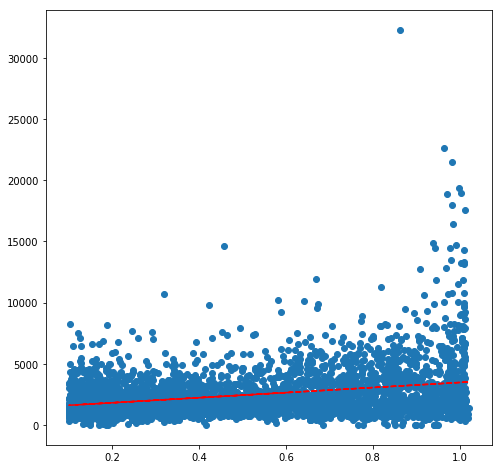

In [140]:
import matplotlib.pyplot as plt
plt.subplots(figsize=(8,8))
y = pop_count
x = filter_by_builtup['PCNT_built']
plt.scatter(x, y)

z = np.polyfit(x, y, 1)
p = np.poly1d(z)
plt.plot(x,p(x),"r--")
plt.show()

### Analysis

Get the list of dependent variables from the DataFrame to store in list y_vars

In [141]:

y_var = list(filter_by_builtup.axes[1])[429]
y_var

'PCNT_built'

Get a list of all independent variables from the DataFrame in list all_x

In [142]:
all_x = list(filter_by_builtup.axes[1])[3:426]

#Check
all_x

['fourier_v2_sc31_mean_mean',
 'fourier_v2_sc31_mean_std',
 'fourier_v2_sc31_mean_sum',
 'fourier_v2_sc31_variance_mean',
 'fourier_v2_sc31_variance_std',
 'fourier_v2_sc31_variance_sum',
 'fourier_v2_sc51_mean_mean',
 'fourier_v2_sc51_mean_std',
 'fourier_v2_sc51_mean_sum',
 'fourier_v2_sc51_variance_mean',
 'fourier_v2_sc51_variance_std',
 'fourier_v2_sc51_variance_sum',
 'fourier_v2_sc71_mean_mean',
 'fourier_v2_sc71_mean_std',
 'fourier_v2_sc71_mean_sum',
 'fourier_v2_sc71_variance_mean',
 'fourier_v2_sc71_variance_std',
 'fourier_v2_sc71_variance_sum',
 'gabor_sc3_filter_1_mean',
 'gabor_sc3_filter_1_std',
 'gabor_sc3_filter_1_sum',
 'gabor_sc3_filter_10_mean',
 'gabor_sc3_filter_10_std',
 'gabor_sc3_filter_10_sum',
 'gabor_sc3_filter_11_mean',
 'gabor_sc3_filter_11_std',
 'gabor_sc3_filter_11_sum',
 'gabor_sc3_filter_12_mean',
 'gabor_sc3_filter_12_std',
 'gabor_sc3_filter_12_sum',
 'gabor_sc3_filter_13_mean',
 'gabor_sc3_filter_13_std',
 'gabor_sc3_filter_13_sum',
 'gabor_sc3_fi

### Compute Coorelation of features with population density

Store all features with the least correlation (stat. significance (p < 0.05)) 

In [143]:


y_dict = {}
x = []

for x_var in all_x:
    
    #Calculate the Pearson statistics, 
    # returns the Pearson value and p value
    
    p = stats.pearsonr(filter_by_builtup[x_var],pop_count)
    
    # print back for mike
    print (y_var + " , " + x_var + " , " +  str(p[0]) + " , " + str(p[1]))
    
    #If p < 0.05 append to list x
    if p[1] < 0.05:
        x.append([x_var,abs(p[0])])

#List x is made into a DataFrame 
# which is sorted by the absolute values of the Pearson values
x_df = pd.DataFrame(x,columns=["x_var","abs_r2"]).sort_values("abs_r2",ascending=False)


#The dependent variable dictionary is given an entry 
# where the key is the name of the dependent variable
# and the value is a list of top 200 most significant values

y_dict[y_var] = list(x_df["x_var"][0:294])

#Print out each dependent variable and 
#the number of x values that remain to check completion

for key in y_dict.keys():
    print(key,len(y_dict[key]))


PCNT_built , fourier_v2_sc31_mean_mean , 0.240073366984 , 2.87163581372e-50
PCNT_built , fourier_v2_sc31_mean_std , -0.00545208613436 , 0.73866007617
PCNT_built , fourier_v2_sc31_mean_sum , 0.251284381103 , 4.68654782065e-55
PCNT_built , fourier_v2_sc31_variance_mean , 0.0390018426174 , 0.0169624059393
PCNT_built , fourier_v2_sc31_variance_std , -0.00389581756101 , 0.811574729849
PCNT_built , fourier_v2_sc31_variance_sum , 0.227068090245 , 5.10457396024e-45
PCNT_built , fourier_v2_sc51_mean_mean , 0.250787316519 , 7.73220906971e-55
PCNT_built , fourier_v2_sc51_mean_std , -0.00694104385051 , 0.671023528683
PCNT_built , fourier_v2_sc51_mean_sum , 0.247891881445 , 1.39747669806e-53
PCNT_built , fourier_v2_sc51_variance_mean , 0.0484787348847 , 0.00299479680342
PCNT_built , fourier_v2_sc51_variance_std , 0.00659608938889 , 0.686481582924
PCNT_built , fourier_v2_sc51_variance_sum , 0.228152462317 , 1.91668882857e-45
PCNT_built , fourier_v2_sc71_mean_mean , 0.261070537141 , 1.95177878341e-59

### Correlation Significance

In [144]:
x_df

,x_var,abs_r2
300,orb_sc31_kurtosis_sum,0.418760
309,orb_sc31_skew_sum,0.410646
285,ndvi_sc3_variance_sum,0.352974
343,pantex_sc3_min_sum,0.347100
182,hog_sc7_kurtosis_sum,0.345218
332,orb_sc71_max_sum,0.334806
318,orb_sc51_max_sum,0.332391
303,orb_sc31_max_sum,0.327636
335,orb_sc71_mean_sum,0.316494
346,pantex_sc5_min_sum,0.311720


In [145]:
y = y_var

#Initialize the output dictionary, Y_D, 
# with each key being a dependent variable and the values being the results of the analyses

Y_D = {}

In [146]:
#Dictionary Models is used to store each result object for later use if needed

Models ={}


For each dependent variable y in the list of all dependent values, calibrate the model.
Add new key to the output dictionary where y is the dependent variable curently being processed and the values are empty for now

In [147]:
Y_D[y]={}

#Get independent variables from the variable dictionary and store in list x_vars
x_vars = y_dict[y]

In [148]:
#Create a new dataframe for scaled and centered values
scale_df = pd.DataFrame()

#Scale and center the values
scale_df[y] = scale(pop_density, with_mean=True, with_std=True)

scale_df[y].shape

(3747,)

#### Filter data to less correlated features and compute elastic net

In [149]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler()
#scaled_df = scaler.fit_transform(filter_by_builtup[x])

In [150]:
for x in x_vars:
    scale_df[x] = scale(filter_by_builtup[x], with_mean=True, with_std=True)
    
    
result = ElasticNetCV(max_iter=1e8,
                    alphas = [0.0005, 0.001, 0.01, 0.03, 0.05, 0.1],
                    l1_ratio =[.1, .5, .7, .9, .95, .99, 1],
                    verbose= False,
                    n_jobs = -1, 
                    cv=5, 
                    selection = 'random',
                    fit_intercept=False)


#Fit the model with the scaled data
result.fit(scale_df[x_vars],scale_df[y])
#Append the model to the Models dictionary
Models[y] = result


/Users/adbe/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:164: UserWarning: Numerical issues were encountered when centering the data and might not be solved. Dataset may contain too large values. You may need to prescale your features.
  warnings.warn("Numerical issues were encountered "


In [151]:
result

ElasticNetCV(alphas=[0.0005, 0.001, 0.01, 0.03, 0.05, 0.1], copy_X=True, cv=5,
       eps=0.001, fit_intercept=False,
       l1_ratio=[0.1, 0.5, 0.7, 0.9, 0.95, 0.99, 1], max_iter=100000000.0,
       n_alphas=100, n_jobs=-1, normalize=False, positive=False,
       precompute='auto', random_state=None, selection='random',
       tol=0.0001, verbose=False)

In [152]:
opt_alpha, opt_l1_ratio = result.alpha_, result.l1_ratio_

#Print update to ensure that the script is progressing properly
print("R2: {:.2f} Alpha: {} l1_ratio: {}"
      .format(result.score(scale_df[x_vars],scale_df[y]),
              result.alpha_, result.l1_ratio_))

R2: 0.52 Alpha: 0.1 l1_ratio: 0.1


In [153]:
#Record the overall R squared score and optimal alpha 
# and l1 ratio values and store them in the output dictionary


Y_D[y]['Total R2'] = result.score(scale_df[x_vars],scale_df[y])
Y_D[y]['Alpha'] = opt_alpha
Y_D[y]['l1_ratio'] = opt_l1_ratio

#Create a list R2s to store out of sample R squared values

R2s = []

#Specify the number of trials to run

trials = 10

#Run the number of trials specified in trials, 
#for each trial 34% of the observations are randomly selected to train the model
#Testing is done on the remaining 66% of observations and the R squared values are recorded

for i in range(trials):    
    X_train, X_test, y_train, y_test = train_test_split(scale_df[x_vars], scale_df[y], test_size=0.66)
    test_regr = ElasticNetCV(max_iter=1e8,
                    alphas = [opt_alpha],
                    l1_ratio =[opt_l1_ratio],
                    n_jobs = -1, 
                    cv=5, 
                    selection = 'random',
                    fit_intercept=False)
    test_regr.fit(X_train,y_train)
    R2s.append(test_regr.score(X_test,y_test))

#print("Mean R2: {:.2f} StDev: {:.4f}".format(mean(R2s),pstdev(R2s)))
#Record the out of sample R squared values
Y_D[y]['Sampling']={'trials':trials,'R2':mean(R2s),'StDev':pstdev(R2s),'R2s':R2s}
coefs = [i for i in zip(list(scale_df[x_vars].axes[1]),result.coef_)]
remaining = [i for i in coefs if abs(i[1])>0.0]
Y_D[y]["Coefficients"]=remaining

In [154]:
y_vars = y_var
Y_D[y_var]

{'Total R2': 0.52223958711905671,
 'Alpha': 0.10000000000000001,
 'l1_ratio': 0.10000000000000001,
 'Sampling': {'trials': 10,
  'R2': 0.50428832946257485,
  'StDev': 0.015999016463323752,
  'R2s': [0.48373046690804533,
   0.50244508288476331,
   0.53382379659923518,
   0.4967710470426569,
   0.49778049585319206,
   0.49086573661559485,
   0.50323328463773997,
   0.52117336777158052,
   0.48800944024964804,
   0.5250505760632922]},
 'Coefficients': [('orb_sc31_kurtosis_sum', -0.013175924082781293),
  ('orb_sc31_skew_sum', -0.022884017556215552),
  ('ndvi_sc3_variance_sum', -0.012964193437172573),
  ('pantex_sc3_min_sum', -0.0045114478456768818),
  ('hog_sc7_kurtosis_sum', -0.13652531518792824),
  ('pantex_sc5_min_sum', -0.0094370079010896203),
  ('hog_sc5_kurtosis_sum', -0.069386805457238215),
  ('pantex_sc7_min_sum', -0.0043606055927244997),
  ('orb_sc71_mean_mean', 0.049174425074681352),
  ('orb_sc71_max_mean', 0.067486883326390176),
  ('orb_sc51_max_mean', 0.015278655364894913),
  (